Here's a demonstration of the Modifiable Areal Unit Problem using randomly generated data.

###Imports

* Geopandas - pandas, but extended to use Shapely geometric objects
* Numpy - random, correlation coefficient
* Shapely - Geometric objects

In [10]:
import geopandas as gpd
from numpy import random,corrcoef,arange
from shapely.geometry import Point,Polygon
import matplotlib.pyplot as plt

###Generate Data

The goal here is generate a 2d space that has a number of points, each with two traits. The value of those traits will be more similar to the points nearby than those far away. We also want the values of the two traits to have some correlation. A real world example would be 

My method for generating this space is to first generate a randomly located point with random values. Then for the rest of the points, randomly generate its location, and the first value will be the mean of the ten nearest points plus or minus a random difference. The second value will be the first value, plus or minus a random difference. The first 10 point generated will be taking the mean value of the entire space.

Also make a function that can generate similar, completely random space.


In [11]:
def build_correlated_gdf(stddev = 40, point_ct = 1000):

    x = random.randint(1, 1000)
    y = random.randint(1, 1000)
    point0 = Point(x, y)
    r1 = random.randint(1,1000)
    gdf = gpd.GeoDataFrame({'geometry':[point0],
                            'value1':[r1],
                            'value2':[r1]}
                           ,index=[0])

    for i in range(point_ct):
        
        # Create a new point in the space, randomly placed
        x = random.randint(1, 1000)
        y = random.randint(1, 1000)
        newPoint = Point(x,y)

        # take the ten nearest points to this new point. take their average
        temp_gdf = gdf.copy()
        temp_gdf['dist'] = temp_gdf['geometry'].apply(lambda p: p.distance(newPoint))
        temp_gdf.sort_values('dist',inplace=True)
        vm = temp_gdf.head(10)['value1'].mean()

        # use this value as the center of a normal distribution, and pick a value randomly on that distribution
        # second value takes the normal dist of diff
        valdiff = random.normal(0, stddev)
        valdiff2 = random.normal(valdiff,stddev)

        # if the value goes outside our bounds, just bounce it back inside
        if ((vm + valdiff) > 1000) | ((vm + valdiff) < 1):
            valdiff = -valdiff
        if ((vm + valdiff2) > 1000) | ((vm + valdiff2) < 1):
            valdiff2 = -valdiff2

        # add the point and the values to the end of the the ongoing geodataframe
        gdf = gdf.append(gpd.GeoDataFrame({'geometry': [newPoint],
                                'value1': [vm+valdiff],
                                'value2': [vm+valdiff2]}
                                , index=[len(gdf)]))

    return gdf

def build_random_gdf(point_ct = 1000):

    vals = [random.randint(1,1000) for i in range(point_ct)]
    vals2 = [random.randint(1,1000) for i in range(point_ct)]
    points = [Point(random.randint(1,1000),random.randint(1,1000)) for i in range(point_ct)]

    return gpd.GeoDataFrame({'value1':vals,'value2':vals2,'geometry':points})



correlated_space = build_correlated_gdf()
random_space = build_random_gdf()


Now that the point spaces have been generated, we need a way to visualize them and aggregate them into zones


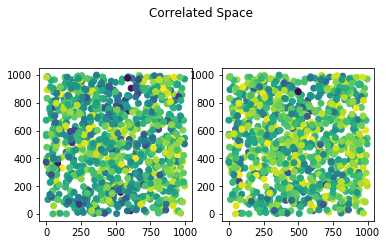

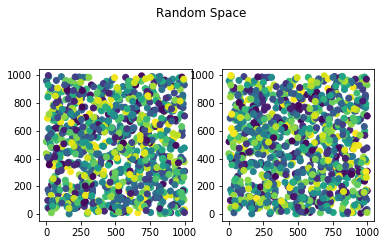

In [12]:
def plot_side_by_side(gdf,title='',):
    fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
    fig.suptitle(title)
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    gdf.plot(ax=ax1,column='value1')
    gdf.plot(ax=ax2,column='value2')
    plt.show()


plot_side_by_side(correlated_space,'Correlated Space')
plot_side_by_side(random_space,'Random Space')

These will always look different, but it should be fairly obvious that there is spacial correlation in the top pair of charts and little to none below.

Now we need a way to aggregate these spaces into zones. For simplicity, all zones will be equal-sized squares.

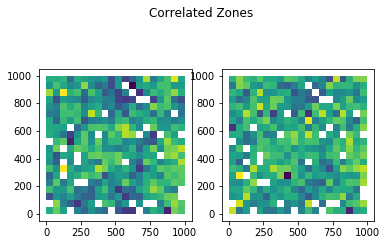

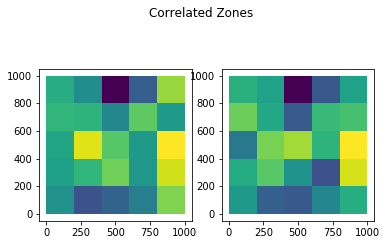

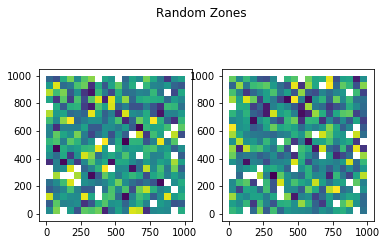

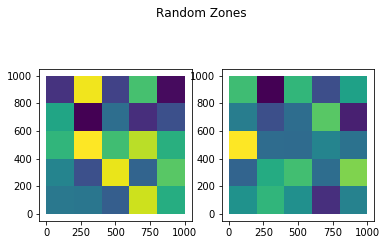

In [13]:
def build_squares(gdf,cells_per_edge=10):
    
    cell_size = 1000/cells_per_edge
    v1 = []
    v2 = []
    polys = []

    for i in arange(0,1000,cell_size):
        for j in arange(0,1000,cell_size):
            this_section = gdf.cx[i:(i+cell_size),j:(j+cell_size)]
            if len(this_section) == 0:
                continue
            else:
                v1.append(this_section['value1'].mean())
                v2.append(this_section['value2'].mean())
                polys.append(Polygon([(i,j),(i,j+cell_size),(i+cell_size,j+cell_size),(i+cell_size,j)]))

    return gpd.GeoDataFrame({'geometry':polys,'value1':v1,'value2':v2})

cor_20 = build_squares(correlated_space,20)
cor_5 = build_squares(correlated_space,5)


plot_side_by_side(cor_20,'Correlated Zones')
plot_side_by_side(cor_5,'Correlated Zones')

rand_20 = build_squares(random_space,20)
rand_5 = build_squares(random_space,5)

plot_side_by_side(rand_20,'Random Zones')
plot_side_by_side(rand_5,'Random Zones')

Finally let's create a list of correlations coefficients of sequential zone sizes.

In [14]:
#takes a while to do all the point selection into squares
cor_squares = [build_squares(correlated_space,c) for c in arange(40,0,-5)]
cor_cors = [corrcoef(cs['value1'],cs['value2'])[1,0] for cs in cor_squares]

rand_squares = [build_squares(random_space,c) for c in arange(40,0,-5)]
rand_cors = [corrcoef(cs['value1'],cs['value2'])[1,0] for cs in rand_squares]




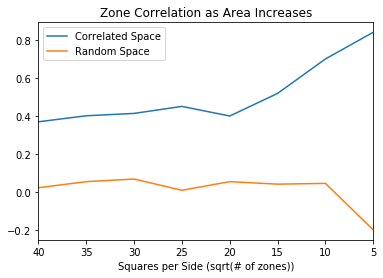

In [15]:
plt.plot(arange(40,0,-5),cor_cors,label='Correlated Space')
plt.plot(arange(40,0,-5),rand_cors,label='Random Space')
plt.xlim(40,5)
plt.xlabel('Squares per Side (sqrt(# of zones))')
plt.title('Zone Correlation as Area Increases')
plt.legend()
plt.show()